## SIM Training by Stein's Method

In [1]:
import numpy as np
from matplotlib import pylab as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, mean_squared_error

from pysim import SIM

## pySIM - A python package for Sparse SIM 

**To install**:
    
```sheel
    pip install git+https://github.com/Zebinyang/pysim.git
```

Note pysim will call the R package fps (https://github.com/vqv/fps) using rpy2 interface. 

**Usage**

```python
from pysim import SIM
clf = SIM(taks="Regression", method="first", spline="augbs", reg_lambda=0.1, reg_gamma=0.1, knot_num=20, degree=2, random_state=0)
## clf.fit(x, y)
```

**Hyperparameters**

- task: the task type, including "Regression" and "Classification". default="Regression"

- method: the base method for estimating the projection coefficients in sparse SIM. default="first"

        "first": First-order Stein's Identity via sparse PCA solver

        "second": Second-order Stein's Identity via sparse PCA solver

        "first_thresholding": First-order Stein's Identity via hard thresholding (A simplified verison)        
    
- spline: The type of spline method. default="augbs"

        "ps": p-spline (from pygam package)
    
        "mono": p-spline with monotonic constraint (from pygam package)
    
        "augbs": adaptive spline where knots are automatically selected (see Goepp, V., Bouaziz, O. and Nuel, G., 2018. Spline regression with automatic knot selection. arXiv preprint arXiv:1808.01770.)

- reg_lambda: The regularization strength of sparsity of beta. default=0.1, from 0 to 1 

- reg_gamma: The regularization strength of the spline algorithm. default=0.1, from 0 to $+\infty$

- degree: The order of the spline basis. default=2

- knot_num: The number of knots spanned uniformly over the domain. default=20

- random_state: the random seed. default=0

# Case 1: Sine Ridge Function

- covariates: $x\sim N(0, 0.3^2)$
- ridge function: $ f(u) = \sin{(u\pi)} $
- projection: $ u = \beta^{T} x $, where $\beta$ has 5 non-zero entries
- noise: $N(0, 1)$
- sample size: 10000
- feature size: 100

In [2]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(0)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = np.sin(np.pi*(np.dot(x, beta))) + np.random.randn(n_samples)

In [9]:
n_samples, n_features = x.shape
sample_weight = np.ones(n_samples) / n_samples
sample_weight

array([0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001])

In [13]:
from pysim.aspline import ASplineClassifier, ASplineRegressor

link_fit_ = ASplineRegressor(knot_num=50, reg_gamma=1,
                                 xmin=x.min(), xmax=x.max(), degree=2)
link_fit_.fit(x, y, sample_weight)

PatsyError: Error evaluating factor: AssertionError: 
    bs(x, knots = knots, degree=degree, include_intercept=True) - 1
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

The best hyperparameter combination can be selected via cross-validation

In [3]:
%%time 

param_grid = {"method": ["first", "second"],
              "reg_lambda": [0.05, 0.1], 
              "reg_gamma": np.logspace(-2, 2, 5)}
grid = GridSearchCV(SIM(task="Regression", degree=2, knot_num=50, spline="augbs", random_state=0), 
                    cv=KFold(3, shuffle=True, random_state=0), param_grid=param_grid, n_jobs=-1, verbose=2, error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  60 | elapsed:   13.6s remaining:   17.8s
[Parallel(n_jobs=-1)]: Done  57 out of  60 | elapsed:   16.0s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   16.2s finished
/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


ValueError: shapes (53,1) and (10000,53) not aligned: 1 (dim 1) != 10000 (dim 0)

In [ ]:
sample_weight = np.ones(53) / 10000
BB = basis.T.dot(sample_weight.reshape([-1, 1])).dot(basis)

In [4]:
grid.best_params_

{'method': 'first', 'reg_gamma': 0.01, 'reg_lambda': 0.05}

**NB**: The first-order Setin's method is selected, as $\mathbb{E}[f^{\prime\prime}(u)]=0$. Therefore, the second order method cannot provide any information about the projection coefficients. 

In this case, the first-order Setin's method is selected. 

In [5]:
clf = grid.best_estimator_
clf

SIM(degree=2, knot_num=50, method='first', random_state=0, reg_gamma=0.01,
    reg_lambda=0.05, spline='augbs', task='Regression')

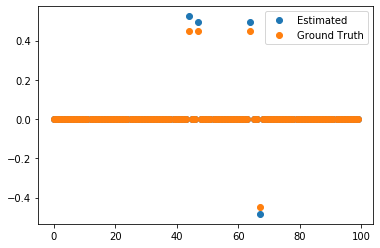

In [6]:
plt.plot(clf.beta_, "o")
plt.plot(beta, "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

In [7]:
clf.visualize_shape_function()
plt.show()

NotFittedError: This ASplineRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

## Case 2: Quadratic Ridge Function

- covariates: $x\sim N(0, 0.3^2)$
- ridge function: $ f(u) = u^{2} $
- projection: $ u = \beta^{T} x $, where $\beta$ has 5 non-zero entries
- noise: $N(0, 1)$
- sample size: 10000
- feature size: 100

In [ ]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(0)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = np.dot(x, beta) ** 2 + np.random.randn(n_samples)

In [ ]:
%%time 

param_grid = {"method": ["first", "second"],
              "reg_lambda": [0.02, 0.04, 0.08, 0.1], 
              "reg_gamma":  np.logspace(-2, 2, 5)}
grid = GridSearchCV(SIM(task="Regression", degree=2, knot_num=100, spline="augbs", random_state=0), 
                    cv=KFold(5, shuffle=True, random_state=0), param_grid=param_grid, n_jobs=-1, verbose=2, error_score=np.nan)
grid.fit(x, y)

In [ ]:
grid.best_params_

**NB**: The second-order Setin's method is selected, as $\mathbb{E}[f^{\prime}(u)]=0$. Therefore, the first order method cannot provide any information about the projection coefficients. 

In [ ]:
clf = grid.best_estimator_
clf

In [ ]:
plt.plot(clf.beta_, "o")
plt.plot(beta, "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

In [ ]:
clf.visualize_shape_function()
plt.show()

## Case 3: Monotonic Ridge Function

- covariates: $x\sim N(0, 0.3^2)$
- ridge function: $ f(u) = e^{-u} $
- projection: $ u = \beta^{T} x $, where $\beta$ has 5 non-zero entries
- noise: $N(0, 1)$
- sample size: 10000
- feature size: 100

In [ ]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(0)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = np.exp(- np.dot(x, beta)) + np.random.randn(n_samples)

- monotonic p-spline

In [ ]:
%%time 

param_grid = {"method": ["first", "second"],
              "reg_lambda": [0.05, 0.1], 
              "reg_gamma":  np.logspace(-2, 2, 5)}
grid = GridSearchCV(SIM(task="Regression", degree=2, knot_num=50, spline="mono", random_state=0), 
                    cv=KFold(5, shuffle=True, random_state=0), param_grid=param_grid, n_jobs=-1, verbose=2, error_score=np.nan)
grid.fit(x, y)

In [ ]:
plt.plot(grid.best_estimator_.beta_, "o")
plt.plot(beta, "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

In [ ]:
grid.best_estimator_.visualize_shape_function()
plt.show()